# Test/experimental notebook to visually verify IPC library (Phasepack) functionality works 

# Imports

In [80]:
import phasepack
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import os

## One image example

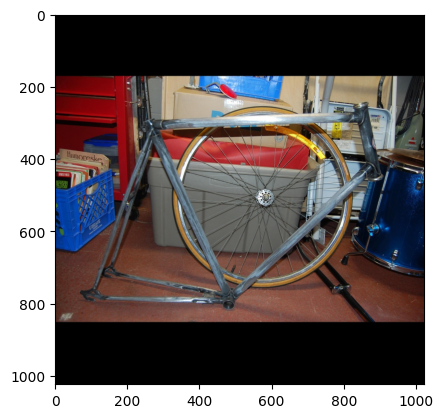

In [105]:
#img = Image.open("/Users/KayK/projects/bv-proj/data/DIS-TR/im-good/4#Architecture#4#Fence#7841963038_f78249af4b_o.jpg").convert("RGB")
#img = Image.open("/Users/KayK/projects/bv-proj/data/DIS-TR/im-good/4#Architecture#4#Fence#7841963038_f78249af4b_o.jpg").convert("RGB")
#img = Image.open("../data/DIS-TE3/im-good/1#Accessories#1#Bag#23874064818_0f48ebc912_o.jpg").convert("RGB")
img = Image.open("/Users/KayK/projects/bv-proj/data/DIS-TE3/im-good/10#Frame#2#BicycleFrame#3873226080_c8ed2d5f66_o.jpg").convert("RGB")
plt.imshow(img)

In [106]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),   
])
img = transform(img)
img = np.array(img)

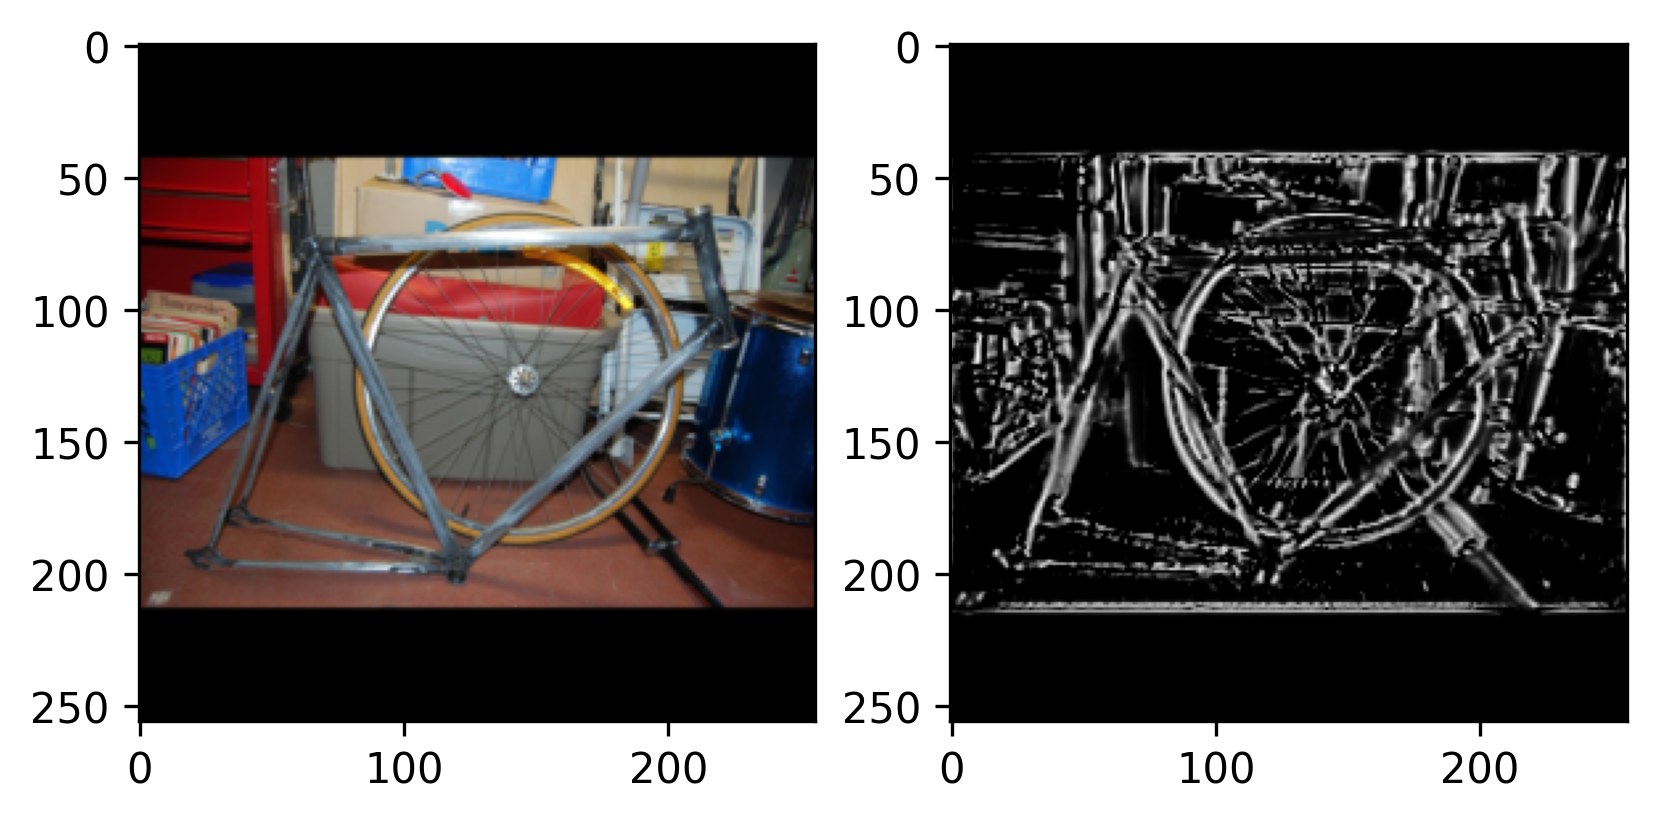

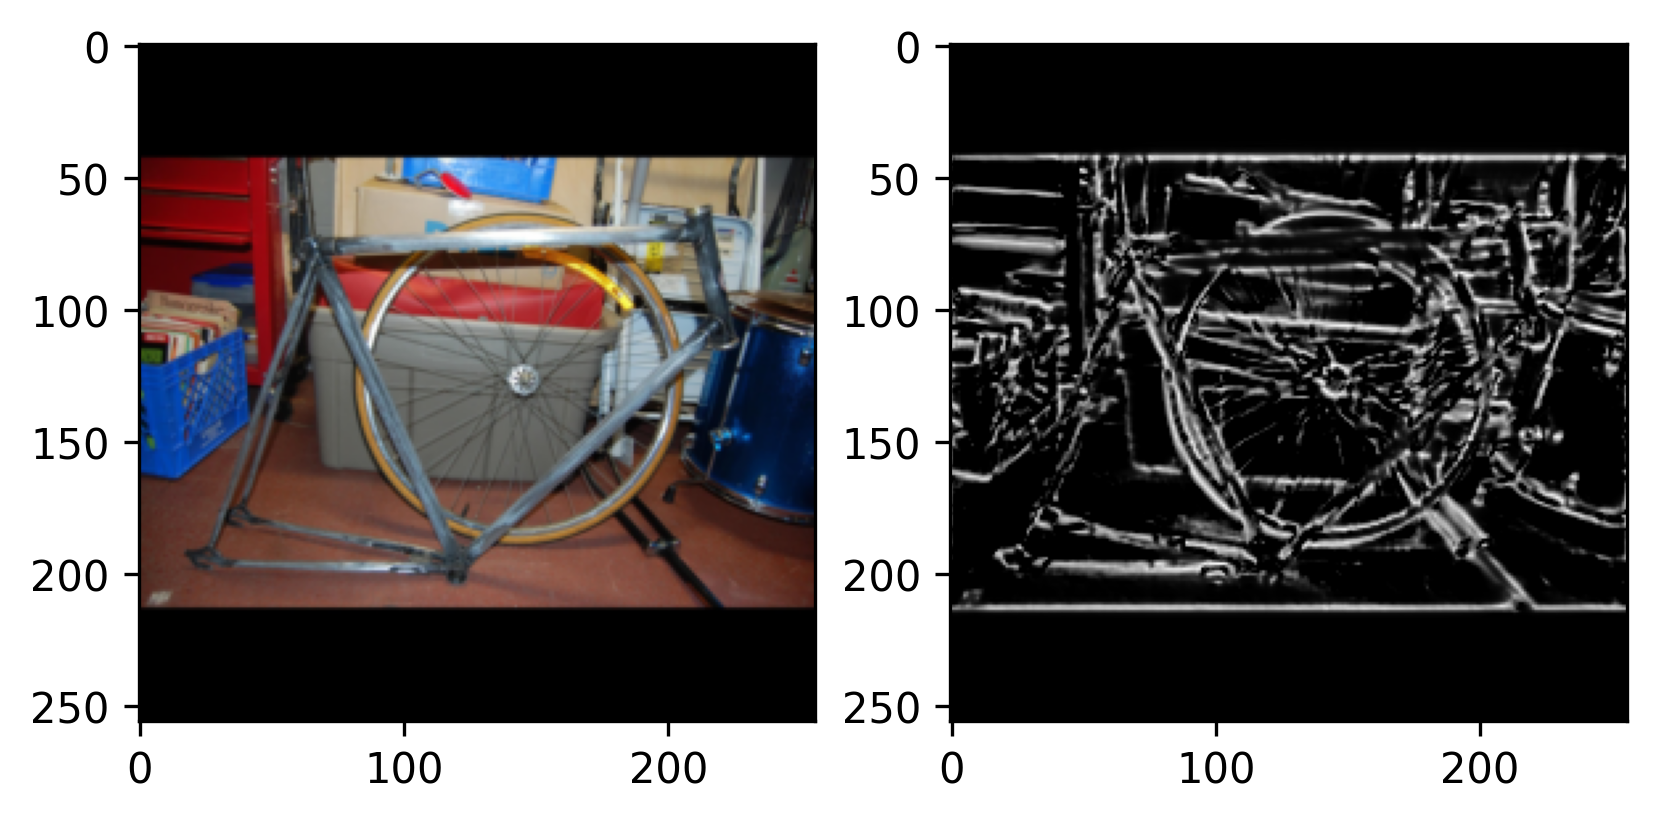

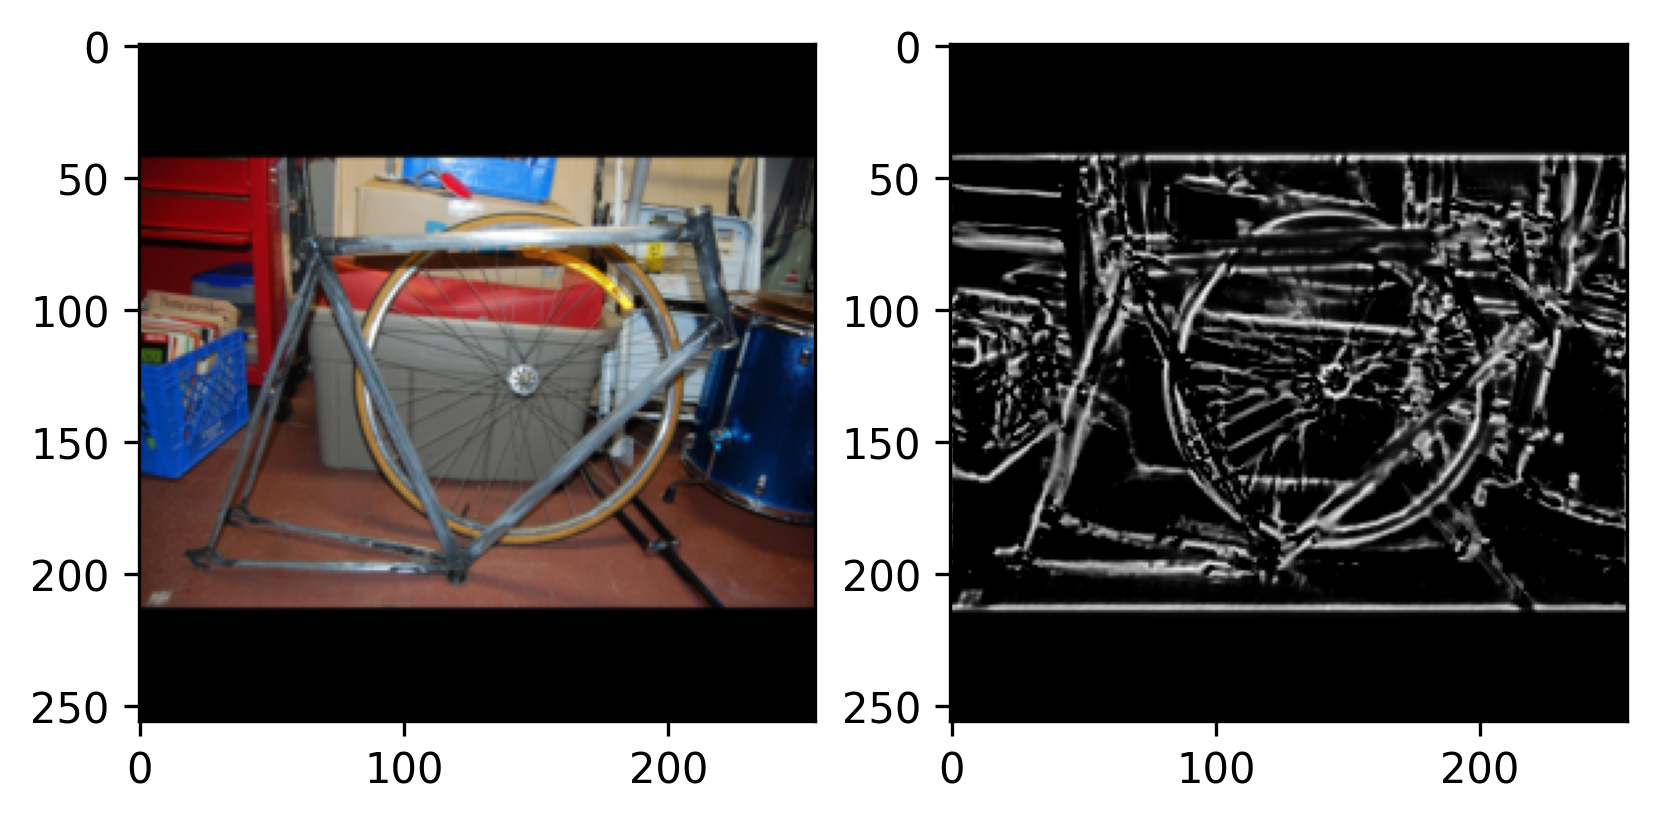

In [107]:
M, m, ori, ft, PC, EO, T = phasepack.phasecong(img, nscale=3, norient=3)

for img2 in PC:
    fig, ax = plt.subplots(1, 2, dpi=300)
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img2, cmap='gray')

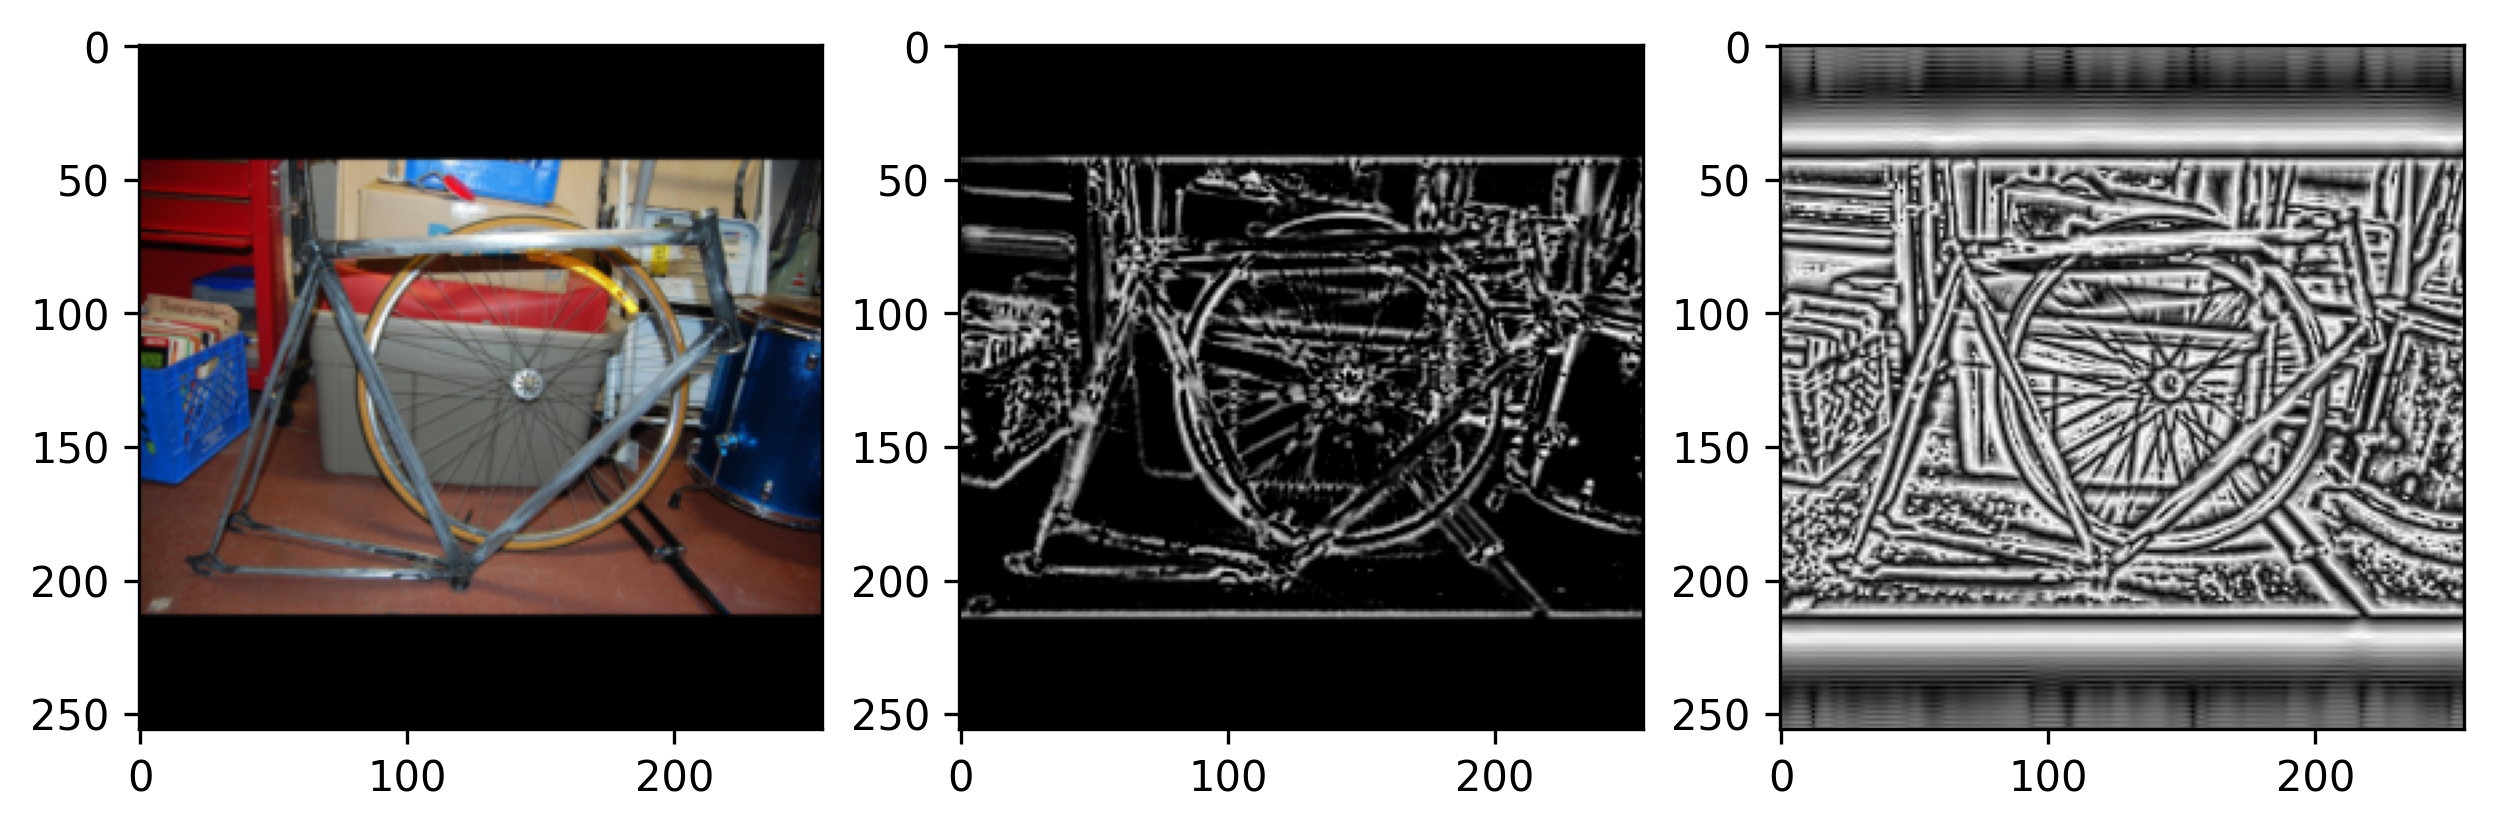

In [108]:
M, ori, ft, T = phasepack.phasecongmono(img, nscale=2)

fig, ax = plt.subplots(1, 3, figsize=(10,5), dpi=300)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(M, cmap='gray')
ax[2].imshow(ft, cmap='gray')

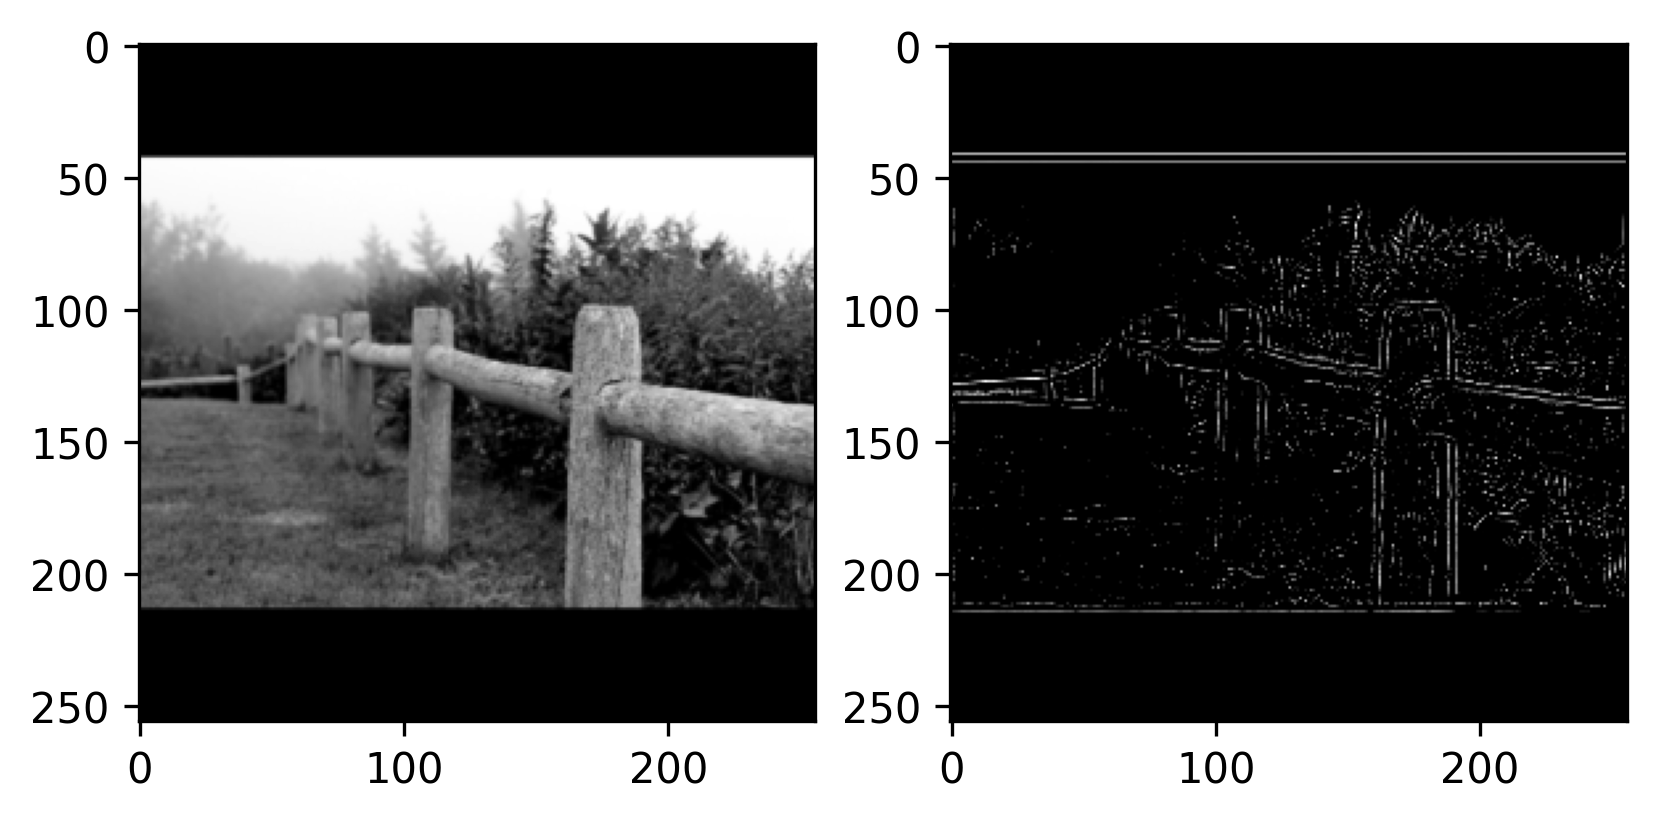

In [74]:
phasesym, ori, totalenergy, T = phasepack.phasesym(img, nscale=2)

fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(phasesym, cmap='gray')


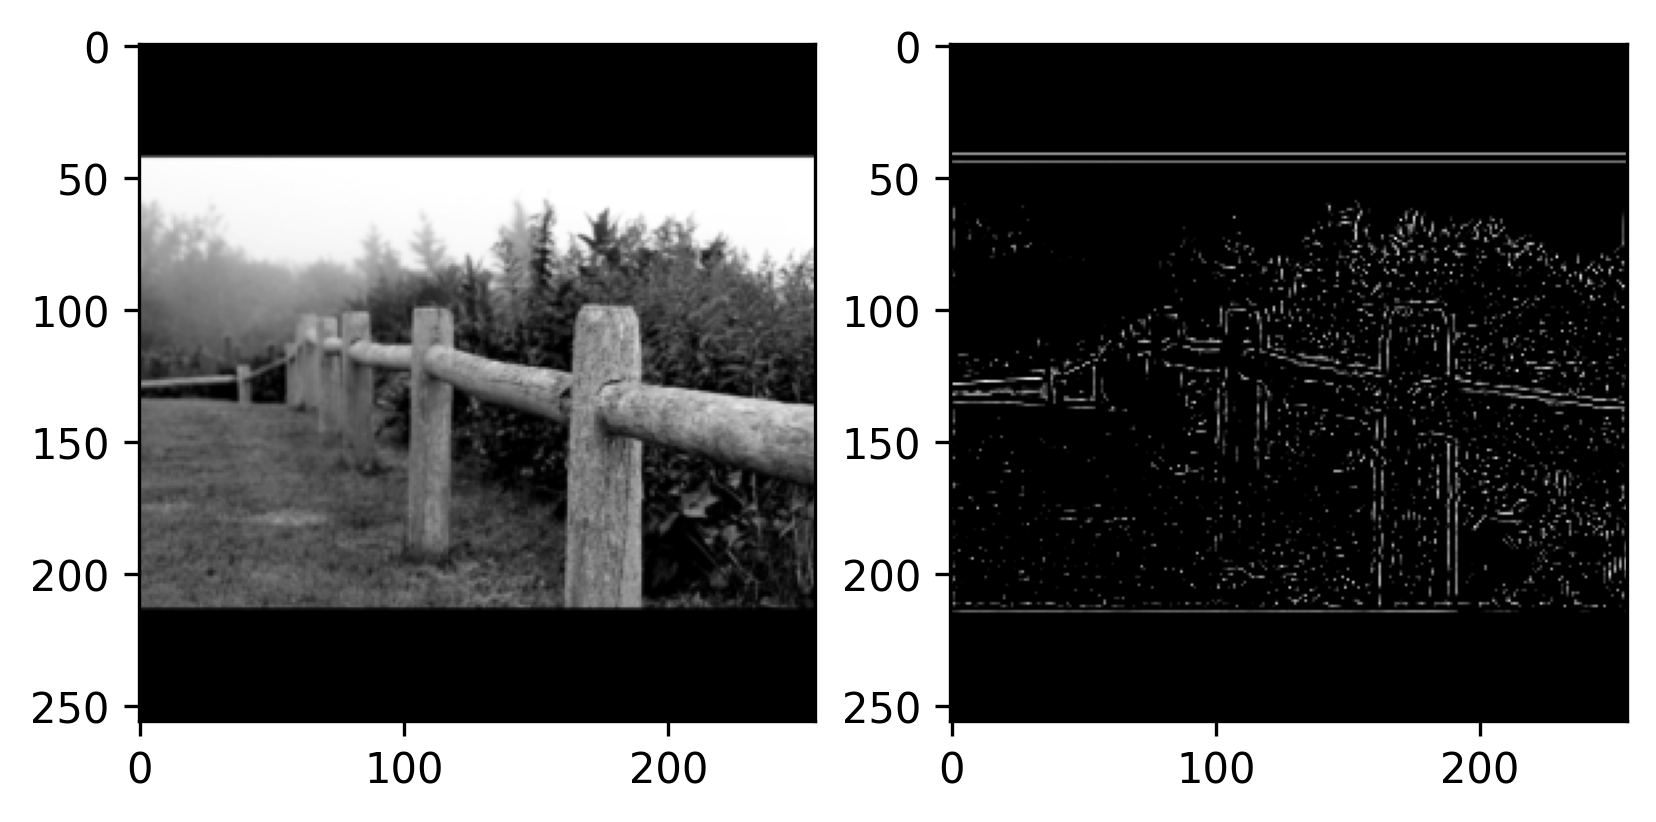

In [75]:
phasesym, totalenergy, T = phasepack.phasesymmono(img, nscale=2)

fig, ax = plt.subplots(1, 2, dpi=300)
ax[0].imshow(img, cmap='gray')
ax[1].imshow(phasesym, cmap='gray')

### ideas 
- get either
    - phase cong set of ori images 
    - singular phase/ft set
    - add as additional channels with RGB
    - so more input channels (RGB + IPC)

### full pipeline

In [ ]:
class IPCTransform:
    def __init__(self, nscale=3, k=2.0):
        """
        nscale: Number of wavelet scales, try values 3-6
        k: No. of standard deviations of the noise energy
                            beyond the mean at which we set the noise threshold
                            point. You may want to vary this up to a value of
                            10 or 20 for noisy images
        """
        self.nscale = nscale
        self.k = k

    def __call__(self, input_image):
        """Apply the IPC transform,
        Using fast fourier transforms and
        monogenic filters for greater speed"""
        rgb_image = np.array(input_image)
        M, _, ft, _ = phasepack.phasecongmono(rgb_image,
                                                nscale=self.nscale,
                                                k=self.k)
        print(ft.shape)
        print(rgb_image[:,:,0].shape)
        """
        Add 2 channels:
        M: Maximum moment of phase congruency covariance, which can be used
            as a measure of edge strength
        ft: Local weighted mean phase angle at every point in the image. A
            value of pi/2 corresponds to a bright line, 0 to a step and -pi/2
            to a dark line
        """
        five_channel_img = np.stack([rgb_image[:,:,0], 
                                     rgb_image[:,:,1], 
                                     rgb_image[:,:,2], 
                                     M, ft],
                                     axis=2)
        print(five_channel_img.shape)
        return five_channel_img

(256, 256)
(256, 256)
(256, 256, 5)


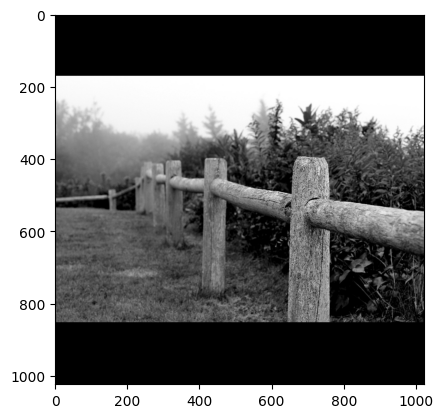

In [69]:
img = Image.open("/Users/KayK/projects/bv-proj/data/DIS-TR/im-good/4#Architecture#4#Fence#7841963038_f78249af4b_o.jpg").convert("RGB")
plt.imshow(img)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    IPCTransform()
])
img = transform(img)

## Preprocess all images raw images with IPC

In [89]:
train_data = "/Users/KayK/projects/bv-proj/data/DIS-TR"
valid_data = "/Users/KayK/projects/bv-proj/data/DIS-VD"
test_data = "/Users/KayK/projects/bv-proj/data/DIS-TE"

In [92]:
def ipc_dataset(parent_folder, nscale=3, k=2.0):
    input_folder = f"{parent_folder}/im-good/"
    output_folder = f"{parent_folder}/ipc-good/"

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        try:
            with Image.open(input_path).convert("RGB") as img:
                img = np.array(img)
                M, _, ft, _ = phasepack.phasecongmono(img,
                                                nscale=nscale,
                                                k=k)     
                M = cv2.normalize(M, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
                cv2.imwrite(output_path, M)
                print(f"Processed: {filename}")
        except Exception as e:
            print(f"Skipping {filename}: {e}")


In [93]:
ipc_dataset(test_data, nscale=3, k=4.0)

Processed: 11#Furniture#18#TableChair#6960946159_10c0ba78fc_o.jpg
Processed: 6#Automobile#4#ConcretePumpTruck#50177270021_6f0b38b243_o.jpg
Processed: 12#Graphics#1#Diagram#8895935967_cde79d0e9e_o.jpg
Processed: 20#Sports#12#TableTennis#14508855975_00daa44ef8_o.jpg
Processed: 2#Aircraft#7#UAV#3795673241_f6f1789809_o.jpg
Processed: 4#Architecture#13#Sculpture#IMG_20210512_191907.jpg
Processed: 4#Architecture#2#Bridge#5670290643_2983390bf2_o.jpg
Processed: 2#Aircraft#1#Airplane#8099096128_6e6529fa4c_o.jpg
Processed: 7#Electrical#6#StreetLamp#3392542579_fb5d1b71a0_o.jpg
Processed: 11#Furniture#18#TableChair#IMG_20210528_112708.jpg
Processed: 16#Music Instrument#1#Drum#2568563453_d2b5cfd55a_o.jpg
Processed: 6#Automobile#6#Excavator#422993_b61a5276f5_o.jpg
Processed: 19#Ship#3#Sailboat#29195132605_6498d74dcc_o.jpg
Processed: 20#Sports#9#RockClimbing#4658072994_738c8bb653_o.jpg
Processed: 17#Non-motor Vehicle#2#Bicycle#10315573726_6d50e83d93_o.jpg
Processed: 8#Electronics#2#Camcorder#39780116

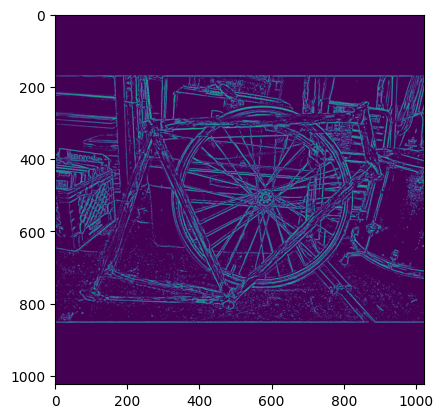

In [88]:
with Image.open("/Users/KayK/projects/bv-proj/data/DIS-TE/im-good/10#Frame#2#BicycleFrame#3873226080_c8ed2d5f66_o.jpg").convert("RGB") as img:
#with Image.open("/Users/KayK/projects/bv-proj/human-data/TR/im-good/4.jpg").convert("RGB") as img:
    img = np.array(img)
    M, _, ft, _ = phasepack.phasecongmono(img, nscale=3, k=4.0)     
    #M.dtype='uint8'
    M = cv2.normalize(M, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    #for line in M:
    #    print(line)
    plt.imshow(M)
    #cv2.imwrite("/Users/KayK/projects/bv-proj/human-data/test_img.png", M)